<h1><center>EE778: Optimal control</center></h1>
<h2><center>Optimal control of 2D undulating motion</center></h2>

## Introduction
Surge-cast is one of the most prominent reactive behavior of insect odor response. It is characterized by straight upwind motion with odor encounter, followed by side-to-side casting motion in the absence of odor. In 2D this motion can be modeled as undulating motion, where an agent has an oscillatory motion in the lateral direction along with the forward motion. Undulating motion is also observed in other biological systems such as fish swimming, snake locomotion etc. For the project required for this class, we will consider a simplified model of undulating motion in 2D. 

## Python Initialization
### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import sympy as sym
import pandas as pd

from sympy import symbols, Eq, solve, simplify, MatrixSymbol
from pprint import pprint
from IPython.display import display, Math, Markdown

from functions import *

%load_ext autoreload
%autoreload 2

### initialization: variables and constants

In [2]:

my_agent = SystemAgent2D()
my_agent.x_dot

Matrix([
[                   F*cos(phi1) - 10*x2],
[                                    x2],
[                   F*sin(phi1) - 10*y2],
[                                    y2],
[-theta1 - theta2 - 100*theta3 + u_freq],
[                                theta3],
[                                theta2],
[           -phi1 - phi2 + tau + theta1],
[                                  phi2]])

## Model
The model assumes a point mass agent moving in 2D space with three control inputs: force ($F$) in the forward direction, torque ($\tau$) to change the heading angle, and ($u_{freq}$) to change the frequency of the undulating motion. The agent has 9 states.

states: $\vec{x} = [x_2, x_1, y_2, y_1, \theta_3, \theta_2, \theta_1]^T, \phi_2, \phi_1$ where $x_2, y_2$ are the velocity in the forward and lateral direction, $x_1, y_1$ are the position in the forward and lateral direction, $\theta_3, \theta_2, \theta_1$ are oscillatory motion and $\phi_2, \phi_1$ are the heading angles.

dynamic equations:
$$
\begin{align*}
\dot{x}_2 &= -c_1 x_2 + F \cos(\phi_1)\\
\dot{x}_1 &= x_2\\
\dot{y}_2 &= -c_2 y_2 + F \sin(\phi_1)\\
\dot{y}_1 &= y_2\\
\dot{\theta}_3 &= -c_3 \theta_3 - c_4 \theta_2 - c_5 \theta_1 + u_{freq}\\
\dot{\theta}_2 &= \theta_3\\
\dot{\theta}_1 &= \theta_2\\
\dot{\phi}_2 &= -c_6 \phi_2 - c_7 \phi_1 + \tau\\
\dot{\phi}_1 &= \phi_2
\end{align*}
$$
where, $c_1, c_2, c_3, c_4, c_5, c_6, c_7$ are system constants.

## Sample responses

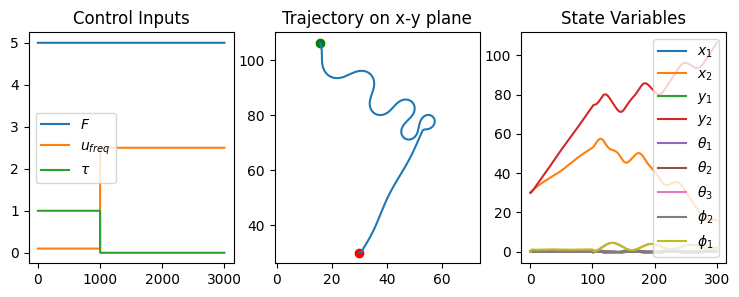

In [3]:
T = 300
dt = .1
N = int(T/dt)
timeseries = np.linspace(0, T, N)

def sample_response(state, t):
    F, u_freq, tau = sample_control(state, t)
    xdot = f(state, [F, u_freq, tau])
    # xdot = my_agent.f(state, [F, u_freq, tau])
    return xdot

def sample_control(state, t):
    F = 5
    if t < 100:
        u_freq = .1
        tau = 1
    else:
        u_freq = 2.5
        tau = 0
    return [F, u_freq, tau]    

initial_state = [0, 30, 0, 30, 0, 0, 0, 0, 0]
result = sp.integrate.odeint(sample_response, initial_state, timeseries)
xx,yy = result[:,1], result[:,3]
inputs = [sample_control(result[i], timeseries[i]) for i in range(len(result))]

fig, [ax,bx,cx] = plt.subplots(1,3, figsize=(9,3))
ax.plot(inputs, label=['$F$', '$u_{freq}$', '$\\tau$'])
ax.legend()
ax.set_title('Control Inputs')
bx.plot(xx, yy)
bx.scatter(xx[0], yy[0], c='r')
bx.scatter(xx[-1], yy[-1], c='g')
bx.axis('equal')
bx.set_title('Trajectory on x-y plane')
cx.plot(timeseries, result, label=['$x_1$', '$x_2$', '$y_1$', '$y_2$', '$\\theta_1$', '$\\theta_2$', '$\\theta_3$', '$\\phi_2$', '$\\phi_1$'])
cx.legend()
cx.set_title('State Variables')
plt.show()

In the above plot, the agent starts from $(30,30)$ and for the first 100 seconds, it moves with low frequency undulating motion. After 100 seconds, the frequency of the undulating motion is increased and the agent moves with high frequency undulating motion. Both the frequency and torque changes agent's heading angle. The state variables have responses that are combination of multiple sinusoidal functions.


In this project, we aim to control the agent to reach a target position $(x_{1_{target}}, y_{1_{target}})$ from an initial position $(x_{1_{initial}}, y_{1_{initial}})$ with oscillatory motion.

# optimal control 

In [4]:
T = 100
dt = 1
N = int(T/dt)
timeseries = np.linspace(0, T, N)
initial_state = [0, 30, 0, 30, 0, 0, 0, 0, 0]
rN = 0, 0, 0, 0, 0, 0, 0, 0, 0



my_agent = SystemAgent2D()

r1, r2, r3 = symbols('r1 r2 r3')
q1, q2, q3, q4, q5, q6, q7, q8, q9 = symbols('q1 q2 q3 q4 q5 q6 q7 q8 q9')
R = sym.diag(r1, r2, r3)
Q = sym.diag(q1, q2, q3, q4, q5, q6, q7, q8, q9)
S = np.eye(9)
rN = sym.Matrix(rN)
# L = my_agent.u.dot(my_agent.u)
L = my_agent.u.T * R * my_agent.u + my_agent.states.T * Q * my_agent.states
L = L[0]
display(sym.Eq(sym.Symbol('L'), L))

phi = (my_agent.states - rN).T * S * (my_agent.states - rN)
# display(sym.Eq(sym.Symbol('phi'), phi))
display(phi)

hamiltonian = L + my_agent.lmdas.dot(my_agent.x_dot)
display(sym.Eq(sym.Symbol('H'), hamiltonian))

lmdadot = -sym.diff(hamiltonian, my_agent.states)
display(lmdadot)

optimal_u = sym.diff(hamiltonian, my_agent.u)
display(optimal_u)
eq2 = sym.Eq(optimal_u, sym.zeros(3,1))
display(eq2)
optimal_u = sym.solve(eq2, my_agent.u)
display(optimal_u)

lmdadot = lmdadot.subs(optimal_u)
display(lmdadot)





Eq(L, F**2*r1 + phi1**2*q9 + phi2**2*q8 + q1*x2**2 + q2*x1**2 + q3*y2**2 + q4*y1**2 + q5*theta3**2 + q6*theta2**2 + q7*theta1**2 + r2*u_freq**2 + r3*tau**2)

Matrix([[1.0*phi1**2 + 1.0*phi2**2 + 1.0*theta1**2 + 1.0*theta2**2 + 1.0*theta3**2 + 1.0*x1**2 + 1.0*x2**2 + 1.0*y1**2 + 1.0*y2**2]])

Eq(H, F**2*r1 + lambda1*(F*cos(phi1) - 10*x2) + lambda2*x2 + lambda3*(F*sin(phi1) - 10*y2) + lambda4*y2 + lambda5*(-theta1 - theta2 - 100*theta3 + u_freq) + lambda6*theta3 + lambda7*theta2 + lambda8*(-phi1 - phi2 + tau + theta1) + lambda9*phi2 + phi1**2*q9 + phi2**2*q8 + q1*x2**2 + q2*x1**2 + q3*y2**2 + q4*y1**2 + q5*theta3**2 + q6*theta2**2 + q7*theta1**2 + r2*u_freq**2 + r3*tau**2)

Matrix([
[                                 10*lambda1 - lambda2 - 2*q1*x2],
[                                                       -2*q2*x1],
[                                 10*lambda3 - lambda4 - 2*q3*y2],
[                                                       -2*q4*y1],
[                            100*lambda5 - lambda6 - 2*q5*theta3],
[                                lambda5 - lambda7 - 2*q6*theta2],
[                                lambda5 - lambda8 - 2*q7*theta1],
[                                  lambda8 - lambda9 - 2*phi2*q8],
[F*lambda1*sin(phi1) - F*lambda3*cos(phi1) + lambda8 - 2*phi1*q9]])

Matrix([
[2*F*r1 + lambda1*cos(phi1) + lambda3*sin(phi1)],
[                         lambda5 + 2*r2*u_freq],
[                            lambda8 + 2*r3*tau]])

Eq(Matrix([
[2*F*r1 + lambda1*cos(phi1) + lambda3*sin(phi1)],
[                         lambda5 + 2*r2*u_freq],
[                            lambda8 + 2*r3*tau]]), Matrix([
[0],
[0],
[0]]))

{F: -lambda1*cos(phi1)/(2*r1) - lambda3*sin(phi1)/(2*r1),
 tau: -lambda8/(2*r3),
 u_freq: -lambda5/(2*r2)}

Matrix([
[                                                                                                                                           10*lambda1 - lambda2 - 2*q1*x2],
[                                                                                                                                                                 -2*q2*x1],
[                                                                                                                                           10*lambda3 - lambda4 - 2*q3*y2],
[                                                                                                                                                                 -2*q4*y1],
[                                                                                                                                      100*lambda5 - lambda6 - 2*q5*theta3],
[                                                                                                                             

In [5]:
lmda_func = sym.Function('lambda')(sym.Symbol('t'))
lmda_t = []

for i in range(len(my_agent.states)):
    expression = lmdadot[i].subs(my_agent.lmdas[i], lmda_func) - lmda_func.diff(sym.Symbol('t'))
    ode_result = sym.dsolve(expression)
    ode_result = ode_result.rhs.subs(sym.Symbol('C1'), sym.Symbol(f'C{i+1}'))
    lmda_t.append(ode_result)
    
lmda_t = sym.Matrix(lmda_t)
display(lmda_t)

Matrix([
[                                                                                                    C1*exp(10*t) + lambda2/10 + q1*x2/5],
[                                                                                                                         C2 - 2*q2*t*x1],
[                                                                                                    C3*exp(10*t) + lambda4/10 + q3*y2/5],
[                                                                                                                         C4 - 2*q4*t*y1],
[                                                                                             C5*exp(100*t) + lambda6/100 + q5*theta3/50],
[                                                                                             C6 + lambda5*t - lambda7*t - 2*q6*t*theta2],
[                                                                                             C7 + lambda5*t - lambda8*t - 2*q7*t*theta1],
[                 

In [6]:
x_func = sym.Function('x')(sym.Symbol('t'))
x_t = []

xdot = my_agent.x_dot.subs(optimal_u)

for i in range(len(my_agent.states)):
    expression = xdot[i].subs(my_agent.states[i], x_func) - x_func.diff(sym.Symbol('t'))
    ode_result = sym.dsolve(expression)
    ode_result = ode_result.rhs.subs(sym.Symbol('C1'), sym.Symbol(f'D{i+1}'))
    x_t.append(ode_result)
x_t = sym.Matrix(x_t)
display(x_t)

Matrix([
[D1*exp(-10*t) - lambda1*cos(2*phi1)/(40*r1) - lambda1/(40*r1) - lambda3*sin(2*phi1)/(40*r1)],
[                                                                                  D2 + t*x2],
[D3*exp(-10*t) - lambda1*sin(2*phi1)/(40*r1) + lambda3*cos(2*phi1)/(40*r1) - lambda3/(40*r1)],
[                                                                                  D4 + t*y2],
[                                D5*exp(-100*t) - lambda5/(200*r2) - theta1/100 - theta2/100],
[                                                                              D6 + t*theta3],
[                                                                              D7 + t*theta2],
[                                                D8*exp(-t) - lambda8/(2*r3) - phi1 + theta1],
[                                                                                D9 + phi2*t]])

In [7]:
xt0 = x_t.subs(sym.Symbol('t'), 0)  
display(xt0)

# eq = sym.Eq(xt0, np.zeros((9,1)))
initial_state = [0, 30, 0, 30, 0, 0, 0, 0, 0]
solution = []
for i in range(len(my_agent.states)):
    eq = sym.Eq(xt0[i], initial_state[i])
    val = sym.solve(eq, sym.symbols(f'D{i+1}'))[0]
    val = x_t[i].subs(sym.symbols(f'D{i+1}'), val)
    solution.append(val)
solution = sym.Matrix(solution)
display(solution)
states_t0 = solution

Matrix([
[D1 - lambda1*cos(2*phi1)/(40*r1) - lambda1/(40*r1) - lambda3*sin(2*phi1)/(40*r1)],
[                                                                              D2],
[D3 - lambda1*sin(2*phi1)/(40*r1) + lambda3*cos(2*phi1)/(40*r1) - lambda3/(40*r1)],
[                                                                              D4],
[                                 D5 - lambda5/(200*r2) - theta1/100 - theta2/100],
[                                                                              D6],
[                                                                              D7],
[                                             D8 - lambda8/(2*r3) - phi1 + theta1],
[                                                                              D9]])

Matrix([
[-lambda1*cos(2*phi1)/(40*r1) - lambda1/(40*r1) - lambda3*sin(2*phi1)/(40*r1) + (lambda1*cos(2*phi1) + lambda1 + lambda3*sin(2*phi1))*exp(-10*t)/(40*r1)],
[                                                                                                                                              t*x2 + 30],
[-lambda1*sin(2*phi1)/(40*r1) + lambda3*cos(2*phi1)/(40*r1) - lambda3/(40*r1) + (lambda1*sin(2*phi1) - lambda3*cos(2*phi1) + lambda3)*exp(-10*t)/(40*r1)],
[                                                                                                                                              t*y2 + 30],
[                                                  -lambda5/(200*r2) - theta1/100 - theta2/100 + (lambda5 + 2*r2*(theta1 + theta2))*exp(-100*t)/(200*r2)],
[                                                                                                                                               t*theta3],
[                                                            

#### unit method

In [8]:
# augmented_states = sym.Matrix([x_t, lmda_t])
augmented_states = sym.Matrix([states_t0, lmda_t])
display(augmented_states)
initial_state = [0, 30, 0, 30, 0, 0, 0, 0, 0]

lambda_0 = np.eye(9)

# sub1 = {my_agent.states[i]: initial_state[i] for i in range(len(my_agent.states))}
# sub2 = {my_agent.lmdas[i]: lambda_0[i] for i in range(len(my_agent.lmdas))}
# val = augmented_states.subs(sub1).subs(sub2)
# val
values = np.zeros((18,1))
for i in range(lambda_0.shape[1]):
    lambda_0_i = lambda_0[:,i]
    sub1 = {my_agent.states[i]: initial_state[i] for i in range(len(my_agent.states))}
    sub2 = {my_agent.lmdas[i]: lambda_0_i[i] for i in range(len(my_agent.lmdas))}
    val = augmented_states.subs(sub1).subs(sub2)
    values += val

Matrix([
[-lambda1*cos(2*phi1)/(40*r1) - lambda1/(40*r1) - lambda3*sin(2*phi1)/(40*r1) + (lambda1*cos(2*phi1) + lambda1 + lambda3*sin(2*phi1))*exp(-10*t)/(40*r1)],
[                                                                                                                                              t*x2 + 30],
[-lambda1*sin(2*phi1)/(40*r1) + lambda3*cos(2*phi1)/(40*r1) - lambda3/(40*r1) + (lambda1*sin(2*phi1) - lambda3*cos(2*phi1) + lambda3)*exp(-10*t)/(40*r1)],
[                                                                                                                                              t*y2 + 30],
[                                                  -lambda5/(200*r2) - theta1/100 - theta2/100 + (lambda5 + 2*r2*(theta1 + theta2))*exp(-100*t)/(200*r2)],
[                                                                                                                                               t*theta3],
[                                                            

In [9]:
values_T = values.subs(sym.Symbol('t'), T)

r_vals = np.array([1, 1, 1])
q_vals = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])
sub3 = {r1: r_vals[0], r2: r_vals[1], r3: r_vals[2]}
sub4 = {q1: q_vals[0], q2: q_vals[1], q3: q_vals[2], q4: q_vals[3], q5: q_vals[4], q6: q_vals[5], q7: q_vals[6], q8: q_vals[7], q9: q_vals[8]}

values_T = values_T.subs(sub3).subs(sub4)
display(values_T)

states_T = sym.Matrix(values_T[:9])
states_T = states_T.evalf()
lambda_T = S * (states_T - rN)
display(sym.Symbol('lambda_T'), lambda_T)

C = []
for i in range(len(my_agent.states), len(my_agent.states)*2):
    eq = values_T[i] - lambda_T[i-9]
    val = solve(eq)
    C.append(val)
C = sym.Matrix(C)
display(sym.Symbol('C'), C)

Matrix([
[   -0.05 + 0.05*exp(-1000)],
[                     270.0],
[                         0],
[                     270.0],
[-0.005 + 0.005*exp(-10000)],
[                         0],
[                         0],
[      -0.5 + 0.5*exp(-100)],
[                         0],
[      9*C1*exp(1000) + 0.1],
[              9*C2 - 54000],
[      9*C3*exp(1000) + 0.1],
[              9*C4 - 54000],
[    9*C5*exp(10000) + 0.01],
[                      9*C6],
[                      9*C7],
[       9*C8*exp(100) + 1.0],
[              9*C9 + 100.0]])

lambda_T

Matrix([
[ -0.05],
[ 270.0],
[     0],
[ 270.0],
[-0.005],
[     0],
[     0],
[  -0.5],
[     0]])

C

Matrix([
[ -8.45993149591576e-437],
[                 6030.0],
[ -5.63995433061051e-437],
[                 6030.0],
[-1.89247310885789e-4346],
[                      0],
[                      0],
[  -6.20012662670139e-45],
[      -11.1111111111111]])

In [10]:
subs = {sym.Symbol(f'C{i+1}'): C[i] for i in range(len(C))}
est_lambda_t = lmda_t.subs(subs).subs(sub3).subs(sub4)
display(sym.Symbol('lambda_t'), est_lambda_t)

est_lambda_t.subs(sym.Symbol('t'), T).evalf()

lambda_t

Matrix([
[                                                                                 lambda2/10 + x2/5 - 8.45993149591576e-437*exp(10*t)],
[                                                                                                                    -2*t*x1 + 6030.0],
[                                                                                 lambda4/10 + y2/5 - 5.63995433061051e-437*exp(10*t)],
[                                                                                                                    -2*t*y1 + 6030.0],
[                                                                         lambda6/100 + theta3/50 - 1.89247310885789e-4346*exp(100*t)],
[                                                                                                  lambda5*t - lambda7*t - 2*t*theta2],
[                                                                                                  lambda5*t - lambda8*t - 2*t*theta1],
[                                      

Matrix([
[                                                                                                    0.1*lambda2 + 0.2*x2 - 0.0166666666666667],
[                                                                                                                            6030.0 - 200.0*x1],
[                                                                                                    0.1*lambda4 + 0.2*y2 - 0.0111111111111111],
[                                                                                                                            6030.0 - 200.0*y1],
[                                                                                             0.01*lambda6 + 0.02*theta3 - 0.00166666666666667],
[                                                                                                 100.0*lambda5 - 100.0*lambda7 - 200.0*theta2],
[                                                                                                 100.0*lambda5 - 100.0*l

In [19]:


# def optimal_response(state, t):
def optimal_response(t, state):
    print(t)
    x2, x1, y2, y1, theta3, theta2, theta1, phi2, phi1 = state
    sub_states = {my_agent.states[i]: state[i] for i in range(len(my_agent.states))}
    lambda_values = est_lambda_t.subs(sub_states).subs(sym.Symbol('t'), t)
    # display(lambda_values.evalf())
    aa = solve(sym.Eq(lambda_values, my_agent.lmdas))
    if isinstance(aa, list):
        aa = aa[0]
    # display(aa)
    lambda_values = sym.Matrix([aa[my_agent.lmdas[i]] for i in range(len(my_agent.lmdas))]).evalf()
    # display(lambda_values)
    optimal_u_values = sym.Matrix([optimal_u.get(uu) for uu in my_agent.u])
    optimal_u_values = optimal_u_values.subs(sub_states).subs(sym.Symbol('t'), t).subs(subs).subs(sub3).subs(sub4).subs(aa)
    # display(optimal_u_values)
    xdot = my_agent.f(state, optimal_u_values)
    return xdot
    

# optimal_response(initial_state, 0)
# result = sp.integrate.odeint(optimal_response, initial_state, timeseries[::10])
result = sp.integrate.solve_ivp(optimal_response, [0, T], initial_state, t_eval=timeseries[::10], method='BDF', rtol=1, atol=1)


0.0
4.538512400287993e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0005742875186182006
0.0005742875186182006
0.0011485750372364012
0.0011485750372364012
0.006891450223418407
0.006891450223418407
0.012634325409600414
0.012634325409600414
0.045291178733670945
0.045291178733670945
0.045291178733670945
0.045291178733670945
0.045291178733670945
0.045291178733670945
0.045291178733670945
0.045291178733670945
0.045291178733670945
0.045291178733670945
0.045291178733670945
0.045291178733670945
0.045291178733670945
0.045291178733670945
0.07794803205774148
0.07794803205774148
0.07794803205774148
0.07794803205774148
0.07794803205774148
0.07794803205774148
0.07794803205774148
0.07794803205774148
0.07794803205774148
0.07794803205774148
0.07794803205774148
0.07794803205774148
0.07794803205774148
0.07794803205774148
0.07794803205774148
0.11060488538181201
0.11060488538181201
0.11060488538181201
0.11060488538181201
0.11060488538181201
0.11060488538181201
0.11060488538181201
0.11060488538181201


KeyboardInterrupt: 

In [ ]:
xx,yy = result[:,1], result[:,3]

plt.plot(xx, yy)
plt.scatter(xx[0], yy[0], c='r')
plt.scatter(xx[-1], yy[-1], c='g')
plt.axis('equal')

[-lambda1*cos(phi1)/(2*r1) - lambda3*sin(phi1)/(2*r1),
 -lambda5/(2*r2),
 -lambda8/(2*r3)]

In [15]:
result = sp.integrate.solve_ivp(optimal_response, [0, T], initial_state, t_eval=timeseries, method='BDF')

[ 0. 30.  0. 30.  0.  0.  0.  0.  0.]


TypeError: cannot unpack non-iterable float object